# 10.4 Visual Analysis of Texts

An important part of Exploratory Data Analysis if data visualization and it is no different for textual data. Visualizing textual data can help us see patterns that our brains could've otherwise not picked up. This section will teach us ways to look at text data. The dataset for this section will be the federalist papers which is processed below:


In [0]:
import pandas as pd
import requests

federalist_dir = "http://dlsun.github.io/pods/data/federalist/"
df_author = pd.read_csv("http://dlsun.github.io/pods/data/federalist/authorship.csv")

df_author = df_author.set_index("Paper")

papers = []
for paper in df_author.index:
    response = requests.get(federalist_dir + str(paper) + ".txt", "r")
    papers.append(response.text)

df_author["Text"] = papers

## N-Gram Frequency

One way to visualize text data is by looking at how often an N-Gram occurs. The simplest way to observe this is by looking at a Unigram (basically its term frequency). This allows us to see how often a specific word is used. In the example below, let us examine how often the authors of the federalist paper mentions the 3 branches of government. 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Create a CountVectorizer like in 10.2
vec = CountVectorizer()
vec.fit(df_author["Text"]) 
tf_sparse = vec.transform(df_author["Text"]).todense()

# Turn the sparse matrix into a Pandas DataFrame 
df_unigram = pd.DataFrame(tf_sparse, columns=vec.get_feature_names(), index=df_author.index)

# Get the three terms we want to examine
df_ngram = df_unigram[["executive", "legislature", "judiciary"]]
df_ngram.sum()

executive      246
legislature    190
judiciary       91
dtype: int64

We can see here the authors of the federalist papers were particularly interested in discussing the executive branch of government. This aligns with consensus understanding of the federalist papers where the three authors were particularly concerned about the overreaching executive. 

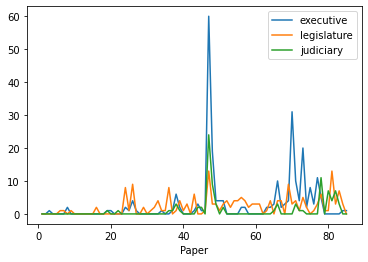

In [4]:
df_ngram.plot.line()

Looking at the line graph, particularly at Federalist 46 (the huge spike in the middle), there is an unusal spike in the number of times all three branches of government are mentioned, which leads us to assume that this paper discusses the government as a whole and not any particular branch. This assumption would be proven right as this essay by Madison is comparing the difference between the state and federal government. 

Another way to interpret this chart would be to treat the papers as a time variable. Since the papers were written in chronological order, we can see that as time went on, the authors wrote more and more about the branches of government.

N-gram analysis provides us with a very simple way to analyze our text by seeing what word(s) occured most frequently. 

## Dimensionality Reduction

While N-grams are great for visualizing a few words over time, it does struggle in visualizing all the documents together. To visualize the whole Count Vector, we will use dimensionality reduction to construct two "Principle Component" vocabulary to present the entire corpus. Recall from the previous chapters that the Principle Component does not represent any real vocabulary but rather it is a mathematical construct that maximizes variance. 

### Representing Documents

In an exercise in section 10.2, we used a the KNN algorithm to predict federalist papers authors. However, one question we may have is whether or not topics plays a role in the classification. Below, we run PCA on the 85 federalist papers, making sure we don't plot points where the author is unknown to simplify our analysis. 

In [5]:
from sklearn.decomposition import PCA
import numpy as np
from altair import *

pca = PCA(n_components=2)
df_data = pca.fit_transform(df_unigram)

# Turn numpy array back into dataframe and reset index 
df_data = pd.DataFrame(df_data, columns=["PCA1", "PCA2"], index=np.arange(1,86,1))

# Merge to get Author name 
df_data = df_data.merge(df_author, left_index=True, right_index=True)

# Drop all papers where the author is not certain 
df_data = df_data[~df_data["Author"].isnull()]
df_data = df_data.reset_index()

Chart(df_data).mark_circle().encode(
    x="PCA1",
    y="PCA2", 
    color="Author",
    tooltip="index"
)

alt.Chart(...)

From above, we can see that the way that the papers are clustered is very much based off the Count Vector of the author. Each author forms a very distinct cluster. Topics doesn't really play a role in this chart as their location in the plot is rather random. For example, Federalist 78 to 83 are papers by Hamilton about the Judiciary but they're they're scattered all throughout the graph.

There are many other dimensionality reduction techniques that could be applied in a similary fashion, experiment with all of them to get the best results. 

### Representing Words

We can apply a similar version of the dimensionality reduction technique to the words of the document. Instead of reducing the number of words there are so we can visualize the documents, we can reduce the number of documents so that we can visualize the words. In this context, PCA creates two new document, PCA Doc 1 and PCA Doc 2, where each value represents the number of times that a word appears in the PCA docs.

-|PCA Document 1|PCA Document 2
---|---|---
**word #1**|times word #1 occur in PCA Doc 1|# of times word #1 occur in PCA Doc 2
**word #2**|...|...

This technique has the added benefit of capturing the meaning of the word. Consider the following block of code where we reduce the number of documents to 2, and plot the words counts.

Text(0.4415900652159762, -0.09777202180619515, 'executive')

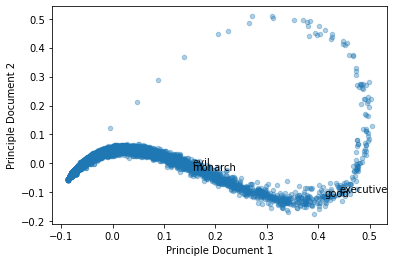

In [6]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Create a CountVectorizer like in 10.2
vec = CountVectorizer()
vec.fit(df_author["Text"]) 
tf_sparse = vec.transform(df_author["Text"]).todense()

# Turn the sparse matrix into a Pandas DataFrame 
df_unigram = pd.DataFrame(tf_sparse, columns=vec.get_feature_names(), index=df_author.index)

# Get the three terms we want to examine
df_unigram = df_unigram.T

# Use a non linear model
pca = KernelPCA(n_components=2, kernel="sigmoid")
df_data = pca.fit_transform(df_unigram)

df_data = pd.DataFrame(df_data, columns=["Principle Document 1", "Principle Document 2"])
ax = df_data.plot.scatter(x="Principle Document 1", y="Principle Document 2", alpha=0.35)

ax.annotate("monarch", tuple(df_data.iloc[list(df_unigram.index).index("monarch")]))
ax.annotate("evil", tuple(df_data.iloc[list(df_unigram.index).index("evil")]))
ax.annotate("good", tuple(df_data.iloc[list(df_unigram.index).index("good")]))
ax.annotate("executive", tuple(df_data.iloc[list(df_unigram.index).index("executive")]))

We know that the writers of the federalist papers tried very hard to convince the American public that the executive under the constitution will be good and just because their actions will be checked by other branches of government. This is in contrast of their view that the unchecked monarch is evil and cruel. This conclusion is definitely supported by our graph above where we see that the word "good" is close to "executive" and "evil" is close to "monarch".

# Exercises

1. Download the nucleotide sequence for Immunodeficient viruses and plot each virus on a 2D scatter plot. Treat every character as its own feature (column). Can you tell which viruses are most similar to each other? 

2. Download the spreadsheet of names at (link) and visualize the names on 2 dimensions. Are you able to derive any meaning from this chart?

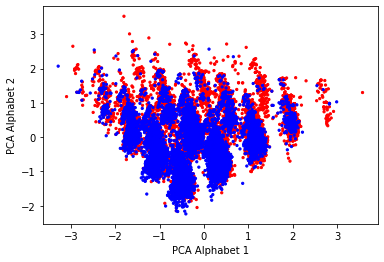

In [33]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd 
import numpy as np
import altair as alt


df_names = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/names/yob2017.txt", header=None)
df_names.columns = ["Name", "Gender", "Number"]
df_names["Names"] = df_names["Name"]
df_names = df_names.set_index("Names")

def count_alpha(string): 
    counts = [0] * 26
    for x in string.lower():
        counts[ord(x) - 97] += 1
    return counts

pca = PCA(n_components=2)
df_data = pd.DataFrame(pca.fit_transform(pd.DataFrame(np.array(list(df_names.Name.apply(count_alpha))))), columns=["PCA Alphabet 1", "PCA Alphabet 2"], index=df_names.index)
df_data = df_data.merge(df_names, left_index=True, right_index=True)
pd.DataFrame(pca.fit_transform(pd.DataFrame(np.array(list(df_names.Name.apply(count_alpha))))), columns=["PCA Alphabet 1", "PCA Alphabet 2"]).plot.scatter(x="PCA Alphabet 1", y="PCA Alphabet 2", c = df_names.Gender.map({"M": "blue", "F": "red"}), s = [5] * df_names.shape[0])
